In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import EarthLocation, AltAz, SkyCoord,ICRS
from astropy.time import Time
import astropy.units as u


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, SkyCoord
import astropy.units as u
from astropy.coordinates import get_sun, get_body

def get_alt_az(ra, dec, time):
    # Convert observation time to UTC
    obs_time_utc = Time(time) - 1 * u.hour
    
    # Observer's location (latitude, longitude, height)
    location = EarthLocation(lat=52.167357 * u.deg, lon=4.461547 * u.deg, height=10 * u.m)
    
    # Convert RA and Dec to SkyCoord object
    sky_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
    
    # Define the AltAz frame for transformation
    altaz_frame = AltAz(obstime=obs_time_utc, location=location)
    
    # Transform coordinates from ICRS (RA/Dec) to AltAz (Altitude/Azimuth)
    altaz = sky_coord.transform_to(altaz_frame)
    
    return altaz.alt, altaz.az

def plot_sun_moon(time, ax):
    # Function to plot celestial coordinates
    def plot_coord(coord, color, name, size=200):
        alt, az = coord.alt.deg, np.deg2rad(coord.az.deg)
        ax.scatter(az, 90 - alt, c=color, s=size, label=name, zorder=5)
        if 90- alt>0 and 90- alt<90:
            ax.text(az, 90- alt, name, fontsize=12, color='black', ha='center', va='bottom',zorder=10)
        
    # Calculate Sun and Moon positions
    obs_time_utc = Time(time) - 1 * u.hour
    location = EarthLocation(lat=52.167357 * u.deg, lon=4.461547 * u.deg, height=10 * u.m)
    
    # Get Sun and Moon AltAz positions
    sun_altaz = get_sun(obs_time_utc).transform_to(AltAz(obstime=obs_time_utc, location=location))
    moon_altaz = get_body('moon', obs_time_utc).transform_to(AltAz(obstime=obs_time_utc, location=location))
    
    # Plot Sun and Moon
    plot_coord(sun_altaz, 'yellow', 'Sun')
    plot_coord(moon_altaz, 'grey', 'Moon')
    
    # Celestial sources with RA and Dec
    sources = {
        'Cassiopeia A': ('23h23m27.94s', '+58d48m42.4s'),
        'Cygnus A': ('19h59m28.36s', '+40d44m02.1s'),
        # 'Taurus A': ('05h34m31.97s', '+22d00m52.1s'),  # Uncomment if needed
        'Virgo A': ('12h30m49.42s', '+12d23m28.0s')
    }

    # Plot celestial sources
    for name, (ra, dec) in sources.items():
        source_coord = SkyCoord(ra, dec, frame='icrs')
        source_altaz = source_coord.transform_to(AltAz(obstime=obs_time_utc, location=location))
        plot_coord(source_altaz, 'blue', name, size=50)
        
    return 

def plot_circular_region(ax, az_center, alt_center, radius, resolution=1000, color='blue', alpha=0.1):
    # Generate a circular region in AltAz coordinates
    az = np.linspace(0, 2 * np.pi, resolution)
    alt = np.linspace(0, np.pi / 2, resolution)
    az_grid, alt_grid = np.meshgrid(az, alt)

    # Calculate angular distance
    angular_distance = np.arccos(np.sin(np.deg2rad(alt_center)) * np.sin(alt_grid) +
                                 np.cos(np.deg2rad(alt_center)) * np.cos(alt_grid) * 
                                 np.cos(az_grid - np.deg2rad(az_center)))
    
    # Mask points within the radius
    mask = angular_distance <= np.deg2rad(radius)
    ax.fill(az_grid[mask], 90 - np.rad2deg(alt_grid[mask]), color=color, alpha=alpha)
    
def plot_galactic_plane(ax, time, shade_color='grey', line_color='black'):
    obs_time_utc = Time(time) - 1 * u.hour
    location = EarthLocation(lat=52.167357 * u.deg, lon=4.461547 * u.deg, height=10 * u.m)

    # Galactic longitude from 0° to 360°
    galactic_longitudes = np.linspace(0, 360, 10000) * u.deg
    latitudes = [-15, 0, 15] * u.deg  # Galactic latitude bounds

    # Convert galactic coordinates to AltAz for ±15° range
    coords_minus15 = SkyCoord(l=galactic_longitudes, b=latitudes[0], frame='galactic').transform_to(AltAz(obstime=obs_time_utc, location=location))
    coords_plane = SkyCoord(l=galactic_longitudes, b=latitudes[1], frame='galactic').transform_to(AltAz(obstime=obs_time_utc, location=location))
    coords_plus15 = SkyCoord(l=galactic_longitudes, b=latitudes[2], frame='galactic').transform_to(AltAz(obstime=obs_time_utc, location=location))

    az_minus15, az_plane, az_plus15 = map(lambda x: np.deg2rad(x.az.deg), [coords_minus15, coords_plane, coords_plus15])
    alt_minus15, alt_plane, alt_plus15 = map(lambda x: 90 - x.alt.deg, [coords_minus15, coords_plane, coords_plus15])

    # Shade the ±15° region around the galactic plane
    ax.fill_between(az_plane, alt_minus15, alt_plus15, color=shade_color, alpha=0.3)

    # Plot the galactic plane as a dashed line
    ax.plot(az_plane, alt_plane, color=line_color, linestyle='--', label="Galactic Plane")

    return



def plot_position(df, time, fov, ax, title='Source Position', tilting=False, alt_center=None, az_center=None):
    # Initialize altitude and azimuth columns
    df['ALT'] = np.zeros(len(df))
    df['AZ'] = np.zeros(len(df))
    
    # Calculate altitude and azimuth for each source
    for i in range(len(df)):
        alt, az = get_alt_az(df.loc[i]['RA'], df.loc[i]['DEC'], time=time)
        df.loc[i, 'ALT'] = alt.value
        df.loc[i, 'AZ'] = az.value
        
    # Encode 'Type' for color mapping
    df['Type_encoded'] = pd.factorize(df['Type'])[0]
    
    # Set grid for radial axis at 15-degree intervals
    ax.set_yticks(np.arange(0, 90, 15))
    ax.set_yticklabels([f'{90 - x}°' for x in np.arange(0, 90, 15)], alpha=0.5)

    # Convert azimuth to radians for polar plot
    az_rad = np.deg2rad(df['AZ'])    
    
    # Scatter plot with altitude as radial distance
    scatter = ax.scatter(az_rad, 90 - df['ALT'], c=df['Type_encoded'], s=25, cmap='tab10')
    
    # Plot Sun and Moon positions
    plot_sun_moon(time, ax)
    
    # Plot galactic plane positions
    plot_galactic_plane(ax, time)
    
    # Set limits for altitude
    ax.set_ylim(0, 90)
    
    # Plot the shadow of the FoV
    azimuths = np.linspace(0, 2 * np.pi, 100)
    shadow_radius = fov / 2
    altitudes = [shadow_radius] * len(azimuths)
    ax.fill(azimuths, altitudes, 'red', alpha=0.1, zorder=0)
    
    # Plot circular region if tilting is enabled
    if tilting:
        plot_circular_region(ax, az_center, alt_center, fov / 2)
    
    # Custom legend for 'Type' categories
    type_labels = df['Type'].unique()
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=type_labels[i],
                           markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in range(len(type_labels))]
    
    plt.legend(title='Type', handles=handles, loc='upper right', bbox_to_anchor=(1.2, 1))
    
    # Set plot title
    ax.set_title('{} at {}'.format(title, time), fontsize=16)

    return df


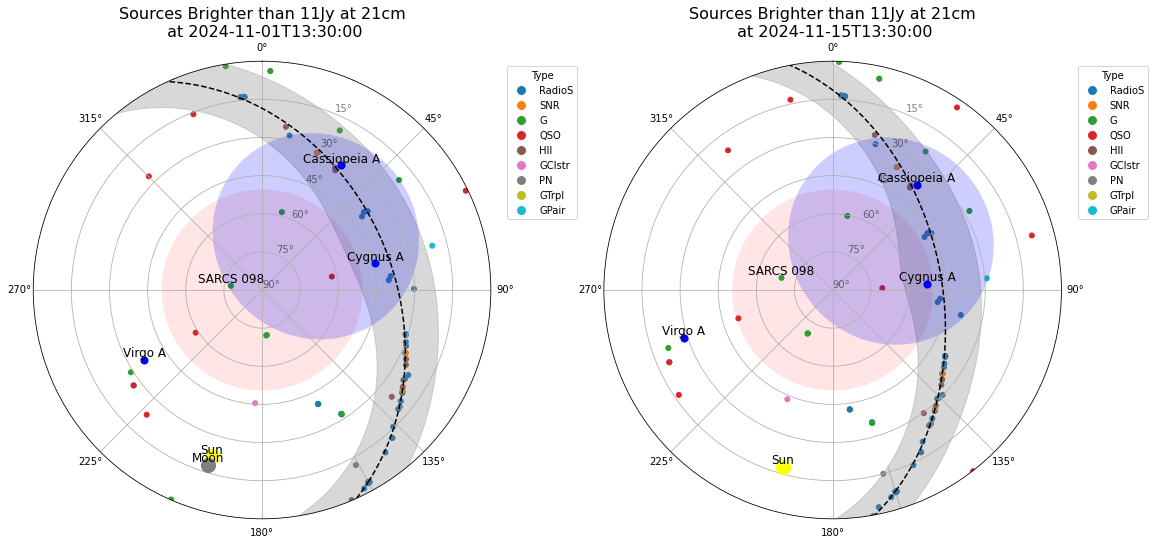

In [40]:
df=pd.read_csv('./sources_brighter_than_11Jy_21cm.txt',skiprows=21,sep='|')

plt.figure(figsize=(16, 8))

ax1 = plt.subplot(121, projection='polar')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
df0111=plot_position(df=df,time="2024-11-01T13:30:00",title='Sources Brighter than 11Jy at 21cm\n',fov=79.06,ax=ax1,\
                       tilting=True,az_center=45,alt_center=60).copy()
ax1.text(np.deg2rad(df0111.iloc[57]['AZ']), 90-df0111.iloc[57]['ALT'], df0111.iloc[57]['Object Name'],\
         fontsize=12, color='black', ha='center', va='bottom')

ax2 = plt.subplot(122, projection='polar')
ax2.set_theta_zero_location("N")
ax2.set_theta_direction(-1)
df1511=plot_position(df=df,time="2024-11-15T13:30:00",title='Sources Brighter than 11Jy at 21cm\n',fov=79.06,ax=ax2,\
                       tilting=True,az_center=50, alt_center=60).copy()
ax2.text(np.deg2rad(df1511.iloc[57]['AZ']), 90-df1511.iloc[57]['ALT'], df1511.iloc[57]['Object Name'],\
         fontsize=12, color='black', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./sources_position.jpg',dpi=300)

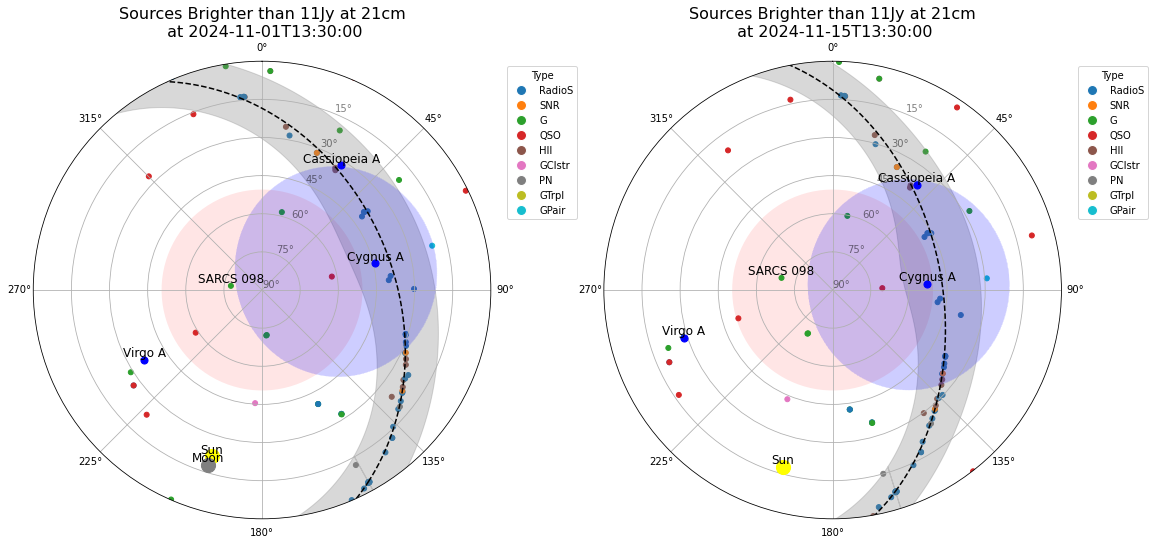

In [41]:
df=pd.read_csv('./sources_brighter_than_11Jy_21cm.txt',skiprows=21,sep='|')

plt.figure(figsize=(16, 8))

ax1 = plt.subplot(121, projection='polar')
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
df0111=plot_position(df=df,time="2024-11-01T13:30:00",title='Sources Brighter than 11Jy at 21cm\n',fov=79.06,ax=ax1,\
                       tilting=True,az_center=76,alt_center=60).copy()
ax1.text(np.deg2rad(df0111.iloc[57]['AZ']), 90-df0111.iloc[57]['ALT'], df0111.iloc[57]['Object Name'],\
         fontsize=12, color='black', ha='center', va='bottom')

ax2 = plt.subplot(122, projection='polar')
ax2.set_theta_zero_location("N")
ax2.set_theta_direction(-1)
df1511=plot_position(df=df,time="2024-11-15T13:30:00",title='Sources Brighter than 11Jy at 21cm\n',fov=79.06,ax=ax2,\
                       tilting=True,az_center=86, alt_center=60).copy()
ax2.text(np.deg2rad(df1511.iloc[57]['AZ']), 90-df1511.iloc[57]['ALT'], df1511.iloc[57]['Object Name'],\
         fontsize=12, color='black', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./sources_position2.jpg',dpi=300)

In [63]:
def degrees_to_dms(degrees):
    # Determine the sign and work with absolute value
    sign = -1 if degrees < 0 else 1
    degrees = abs(degrees)
    
    # Extract degrees
    d = int(degrees)
    
    # Extract minutes
    minutes = (degrees - d) * 60
    m = int(minutes)
    
    # Extract seconds
    seconds = (minutes - m) * 60
    s = round(seconds, 2)  # Adjust precision as needed
    
    # Apply sign to degrees
    d *= sign
    
    return f"{d}°{m}′{s}″"
df0111['ALT(dms)']=df0111['ALT'].apply(degrees_to_dms)
df0111['AZ(dms)']=df0111['AZ'].apply(degrees_to_dms)
df1511['ALT(dms)']=df1511['ALT'].apply(degrees_to_dms)
df1511['AZ(dms)']=df1511['AZ'].apply(degrees_to_dms)

In [51]:
df0111[df0111['ALT']>45][['Object Name','ALT(dms)','AZ(dms)']]
# 3C 286: 15Jy 58
# SARCS 098:  23Jy 77
# WISEA J153955.06+342012.8: 13Jy 72
# 2MASX J15405508+3430155: 16Jy 72
# 3C 380: 15Jy 68
# 3C 390.3: 12Jy 58

# MKW 03s: 115 Jy 45
# Cygnus A: 1598Jy 44.3
# Cassiopeia A: 31.901054, 21.779948

,Object Name,ALT(dms),AZ(dms)
54,3C 286,58°57′48.32″,237°16′15.89″
57,SARCS 098,77°38′21.36″,277°37′51.47″
58,MKW 03s,45°24′25.39″,183°30′36.27″
59,WISEA J153955.06+342012.8,72°2′6.51″,174°43′42.57″
60,2MASX J15405508+3430155,72°11′15.52″,174°1′10.89″
90,3C 380,62°2′57.07″,79°6′9.85″
95,3C 390.3,58°23′25.0″,14°16′5.83″


In [65]:
df1511[df1511['ALT']>45][['Object Name','ALT(dms)','AZ(dms)']]

,Object Name,ALT(dms),AZ(dms)
54,3C 286,51°16′37.73″,253°16′10.43″
57,SARCS 098,69°19′14.14″,283°20′45.62″
59,WISEA J153955.06+342012.8,70°10′47.99″,209°59′39.36″
60,2MASX J15405508+3430155,70°24′43.74″,209°36′36.97″
90,3C 380,70°26′51.24″,87°50′7.16″
95,3C 390.3,60°16′24.93″,11°13′35.67″
116,3C 403.2,48°26′56.85″,96°37′18.13″
117,Cygnus A,52°41′14.8″,86°5′40.11″
118,NRAO 0621,47°34′28.45″,94°35′3.51″
122,4C +52.48,48°16′31.66″,59°59′7.72″


In [59]:
def get_alt_az(time):
    # Calculate Sun and Moon positions
    obs_time_utc = Time(time) - 1 * u.hour
    location = EarthLocation(lat=52.167357 * u.deg, lon=4.461547 * u.deg, height=10 * u.m)
    
    # Get Sun and Moon AltAz positions
    sun_altaz = get_sun(obs_time_utc).transform_to(AltAz(obstime=obs_time_utc, location=location))
    print('Sun',sun_altaz.alt.dms,sun_altaz.az.dms)
    
    # Celestial sources with RA and Dec
    sources = {
        'Cassiopeia A': ('23h23m27.94s', '+58d48m42.4s'),
        'Cygnus A': ('19h59m28.36s', '+40d44m02.1s'),
        # 'Taurus A': ('05h34m31.97s', '+22d00m52.1s'),  # Uncomment if needed
        'Virgo A': ('12h30m49.42s', '+12d23m28.0s')
    }

    # Plot celestial sources
    for name, (ra, dec) in sources.items():
        source_coord = SkyCoord(ra, dec, frame='icrs')
        source_altaz = source_coord.transform_to(AltAz(obstime=obs_time_utc, location=location))
        print(name,source_altaz.alt.dms,source_altaz.az.dms)
        
    return 

In [60]:
get_alt_az(time="2024-11-01T13:30:00")

Sun dms_tuple(d=21.0, m=42.0, s=44.212798420591355) dms_tuple(d=196.0, m=45.0, s=16.639878639728067)
Cassiopeia A dms_tuple(d=31.0, m=54.0, s=45.64879326329162) dms_tuple(d=32.0, m=28.0, s=36.58016454961739)
Cygnus A dms_tuple(d=44.0, m=19.0, s=51.2202830765068) dms_tuple(d=76.0, m=36.0, s=49.54475935084815)
Virgo A dms_tuple(d=36.0, m=8.0, s=18.10575406409896) dms_tuple(d=239.0, m=13.0, s=0.038636221831893636)


In [61]:
get_alt_az(time="2024-11-15T13:30:00")

Sun dms_tuple(d=17.0, m=49.0, s=23.762451885422422) dms_tuple(d=195.0, m=42.0, s=58.95393302163711)
Cassiopeia A dms_tuple(d=36.0, m=50.0, s=27.314832023296276) dms_tuple(d=38.0, m=41.0, s=0.052737071632122934)
Cygnus A dms_tuple(d=52.0, m=41.0, s=14.755763496722238) dms_tuple(d=86.0, m=5.0, s=40.07816856749287)
Virgo A dms_tuple(d=28.0, m=25.0, s=40.72016609609932) dms_tuple(d=252.0, m=19.0, s=41.94131713044044)
